In [135]:
println("Yay for Julia")

Yay for Julia


In [136]:
using LinearAlgebra
using ForwardDiff

using OSQP
using Compat.SparseArrays

using Plots
gr()

Plots.GRBackend()

# Define Environment

In [137]:
include("spacecraft.jl")

Main.Spacecraft

In [138]:
sc = Spacecraft
f = Spacecraft.f
g = Spacecraft.g
h = Spacecraft.h
V = Spacecraft.V

umax = Spacecraft.umax

0.25

In [111]:
# testing things:
x0 = [0.1, -0.01, 0,0, 0];
@show x0

@show f(x0);

@show g(x0);

@show V(x0);

@show h(x0);

x0 = [0.1, -0.01, 0.0, 0.0, 0.0]
f(x0) = [0.0, 0.0, 3.852066055298753e-7, -5.688981192603172e-13, 0.010471975511965976]
g(x0) = [0.0 0.0; 0.0 0.0; 0.001 0.0; 0.0 0.001; 0.0 0.0]
V(x0) = 0.9625760000000002
h(x0) = 0.998429054264871


# Setup ICCBFs

In [112]:
function Lie(h, f)
    # returns a function that computes the Lie Derivative of h along f
    function Lfh(x)
        return ForwardDiff.gradient(h, x)' * f(x)
    end
    return Lfh
end

Lie (generic function with 1 method)

In [113]:
LfV = Lie(V, f);
LgV = Lie(V, g);

Lfh = Lie(h, f);
Lgh = Lie(h, g);

In [114]:
# testing
@show LfV(x0)

@show LgV(x0)

@show Lfh(x0)

@show Lgh(x0)

LfV(x0) = 0.00012545782323483072
LgV(x0) = [0.1952 -0.02]
Lfh(x0) = -0.10933343407547351
Lgh(x0) = [0.0 0.0]


1×2 Adjoint{Float64,Array{Float64,1}}:
 0.0  0.0

In [115]:
# define ICCBF

b0(x) = h(x)
Lfb0 = Lie(b0, f)
Lgb0 = Lie(b0, g)

α0(h) = 0.25*h
b1(x) = Lfb0(x) - norm(Lgb0(x), Inf) * umax + α0(b0(x))
Lfb1 = Lie(b1, f)
Lgb1 = Lie(b1, g);

α1(h) = 0.85*h
b2(x) = Lfb1(x) - norm(Lgb1(x), Inf) * umax + α1(b1(x))
Lfb2 = Lie(b2, f)
Lgb2 = Lie(b2, g);

α2(h) = 0.05 * h

α2 (generic function with 1 method)

# Define Controller

In [116]:
# define the controller 
struct Controller
    prob
    A_con
    l_con
    u_con
end

function setup_controller(x0)
    
    #x0 is a dummy, just to get the correct matrices set up
    
    # Define problem data
    P = sparse(diagm([1.,1, 0, 0]))
    q = [0, 0, 10.0, 50.0]

    # generate constraints
    A_con, l_con, u_con = genConstraints(x0)
    
    # Create OSQP object
    prob = OSQP.Model()

    # Setup workspace and change alpha parameter
    OSQP.setup!(prob; P=P, q=q, A=A_con, l=l_con, u=u_con, verbose=0)
    
    return Controller(prob, A_con, l_con, u_con)
end

function genConstraints(x)
    
    # this is called once, and allocates memory
    # all the constraints are specified 
    
    kv = 0.1 * V(x)
    lfv = LfV(x)
    lgv = LgV(x)

    h = b2(x)
    lfh = Lfb2(x)
    lgh = Lgb2(x)

    αh  = α2(h)
    
    A = sparse(zeros(6, 4))

    # CLF:
    A[1,1] = lgv[1]
    A[1,2] = lgv[2]
    A[1,3] = -1
    
    # CBF:
    A[2,1] = -lgh[1]
    A[2,2] = -lgh[2]
    A[2, 4] = -h
    
    # ||u|| < umax
    A[3,1] = 1.0
    A[3,2] = 1.0
    A[4,1] = 1.0
    A[4,2] = -1.0

    # δ>0
    A[5,3] = 1.0
    
    # k>0
    A[6, 4] = 1.0
    
    
    l = [-Inf; -Inf; -umax; -umax; 0; 0]
    u = [- kv - lfv; αh + lfh; umax; umax; Inf; Inf]
    
    
    return A, l, u
end

function updateConstrains!(x, A, l, u)
    
    kv = 0.1 * V(x)
    lfv = LfV(x)
    lgv = LgV(x)
    
    h = b2(x)
    lfh = Lfb2(x)
    lgh = Lgb2(x)
    αh  = α2(h)
    
    A[1,1] = lgv[1]
    A[1,2] = lgv[2]
    
    A[2,1] = -lgh[1]
    A[2,2] = -lgh[2]
    A[2, 4] = -h
    
    u[1] = -kv - lfv
    u[2] = αh + lfh
    
end

function updateConstrains!(x, controller)
    updateConstrains!(x, controller.A_con, controller.l_con, controller.u_con)
end


function feedback!(x, controller)

    # this is the feedback controller
    
    updateConstrains!(x, controller)
    OSQP.update!(controller.prob, Ax = controller.A_con.nzval, u=controller.u_con, l=controller.l_con)
    results = OSQP.solve!(controller.prob)
    
    if  (results.info.status != :Solved)
        println("OSQP did not solve fully!")
        @show x
        return (false, results.x[1:2])
    end

    return (true, results.x[1:2])
end




feedback! (generic function with 1 method)

In [117]:
controller = setup_controller(x0)

Controller(OSQP.Model(Ptr{OSQP.Workspace} @0x00007fd6b3157be0, [3.0e-323, 2.18236621e-314, 2.1823244237e-314, 0.0, 2.182833999e-314, 2.182833999e-314], [3.0e-323, 2.476405545e-314, 2.2101373077e-314, 2.2663566976e-314, 2.2663567134e-314, 2.1823244237e-314], false), 
  [1, 1]  =  0.1952
  [2, 1]  =  -0.0136828
  [3, 1]  =  1.0
  [4, 1]  =  1.0
  [1, 2]  =  -0.02
  [2, 2]  =  -0.135334
  [3, 2]  =  1.0
  [4, 2]  =  -1.0
  [1, 3]  =  -1.0
  [5, 3]  =  1.0
  [2, 4]  =  -0.0546232
  [6, 4]  =  1.0, [-Inf, -Inf, -0.25, -0.25, 0.0, 0.0], [-0.09638305782323486, -0.0357742278416202, 0.25, 0.25, Inf, Inf])

In [118]:
x0 = [0.1, -0.01, 0,0, 0]

5-element Array{Float64,1}:
  0.1
 -0.01
  0.0
  0.0
  0.0

In [139]:
(suc, u) = feedback!(x0, controller)

(true, [-7.78498348720416e-6, 0.24992299744377375])

# Define Simulation 

In [120]:

function simulate(x0, t_max, dt, controller)
    # performs a simple euler step simulation
    
    t = 0.0
    
    # lazy way to initialize vector types
    tt = [t]
    xx = [x0]
    uu = [[0.0,0.0]]
    
    pop!(tt)
    pop!(xx)
    pop!(uu)
    
    
    while (t < t_max)
        

        (suc, u) = feedback!(x0, controller)
        
        if suc == false
            println("Failed at $(t)")
            break
        end        
        
        push!(tt, t)
        push!(xx, x0)
        push!(uu,u)

        # dynamics update
        x0 = x0 + (f(x0) + g(x0) * u) * dt
        t += dt
        
        if sum(abs2.(x0[1:2])) < (sc.rf)^2
            println("Completed : Successful Rendezvous!")
            break
        end

    end
    
    if (t>t_max)
        println("Completed: Reached t_max")
    end
    
    return (tt, xx, uu)
end
    

simulate (generic function with 1 method)

In [121]:
# use a short sim to pre-compile 
tt, xx, uu = simulate(x0, 1, 0.01, controller);

Completed: Reached t_max


# Perform Simulation

this line takes about 20 seconds on my computer.
the first run might take a bit longer

In [122]:
@time tt, xx, uu = simulate(x0, 300, 0.001, controller)

Completed : Successful Rendezvous!
 18.417142 seconds (23.43 M allocations: 20.731 GiB, 21.21% gc time)


([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001  …  52.9899999999672, 52.9909999999672, 52.9919999999672, 52.992999999967196, 52.993999999967194, 52.99499999996719, 52.99599999996719, 52.99699999996719, 52.997999999967185, 52.99899999996718], [[0.1, -0.01, 0.0, 0.0, 0.0], [0.1, -0.01, 3.6868582500787327e-10, 2.4983658965941015e-7, 1.0471975511965977e-5], [0.1000000000003687, -0.009999999750163411, 7.457539092880796e-10, 4.997504814857096e-7, 2.0943951023931954e-5], [0.10000000000111445, -0.009999999250412929, 1.1271632800113847e-9, 7.497017102401625e-7, 3.141592653589793e-5], [0.10000000000224162, -0.009999998500711219, 1.5108578479747999e-9, 9.996699384582424e-7, 4.188790204786391e-5], [0.10000000000375248, -0.00999999750104128, 1.8958582355888556e-9, 1.2496454783947253e-6, 5.235987755982989e-5], [0.10000000000564833, -0.0099999962513958, 2.2817236586777688e-9, 1.4996239697519914e-6, 6.283185307179587e-5], [0.10000000000793006, -0.00999999475177183,

# Plotting

In [123]:
tt[end]

52.99899999996718

In [124]:
px = [x[1] for x in xx]
py = [x[2] for x in xx]
vx = [x[3] for x in xx]
vy = [x[4] for x in xx];
θθ = [x[5] for x in xx];

ux = [u[1] for u in uu];
uy = [u[2] for u in uu];

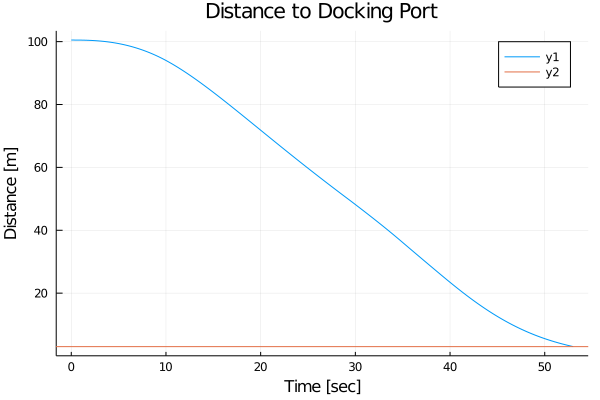

In [125]:
plot(tt, 1000*(sqrt.(px.^2 + py.^2)))
title!("Distance to Docking Port")
xlabel!("Time [sec]")
ylabel!("Distance [m]")
hline!([1000sc.rf])

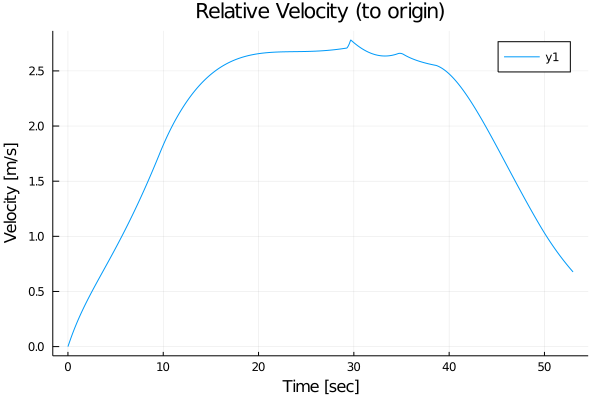

In [126]:
plot(tt, 1000*(sqrt.(vx.^2 + vy.^2)))
title!("Relative Velocity (to origin)")
xlabel!("Time [sec]")
ylabel!("Velocity [m/s]")

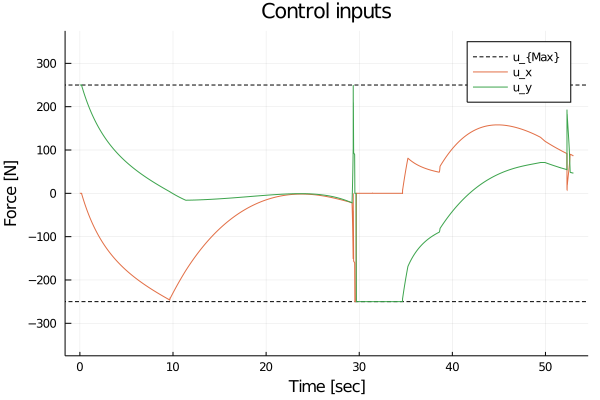

In [127]:
hline([-1000umax, 1000umax], linestyle=:dash, color=:black, label="u_{Max}")
plot!(tt, 1000*ux, label="u_x")
plot!(tt, 1000*uy, label="u_y")
ylims!(-1500*umax, 1500*umax)
title!("Control inputs")
xlabel!("Time [sec]")
ylabel!("Force [N]")


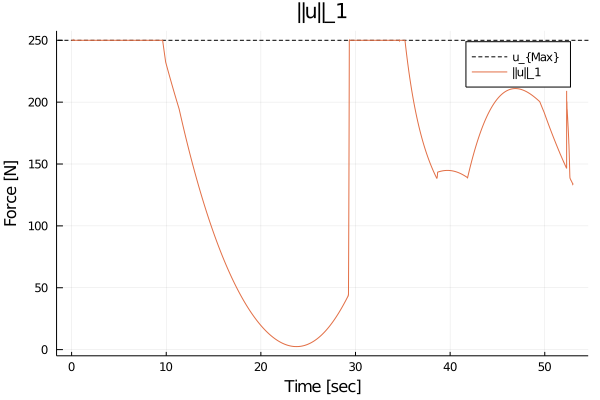

In [128]:
umag = abs.(ux) + abs.(uy)
hline([1000*umax], linestyle=:dash, color=:black, label="u_{Max}")
plot!(tt, 1000umag, label="||u||_1")
title!("||u||_1")
xlabel!("Time [sec]")
ylabel!("Force [N]")


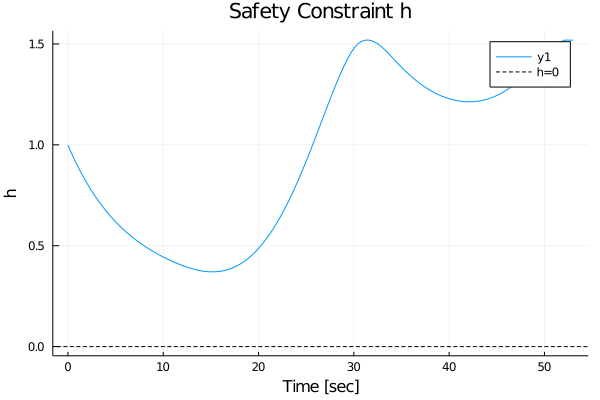

In [130]:
plot(tt, h.(xx))
hline!([0], linestyle=:dash, color=:black, label="h=0")
title!("Safety Constraint h")
xlabel!("Time [sec]")
ylabel!("h")

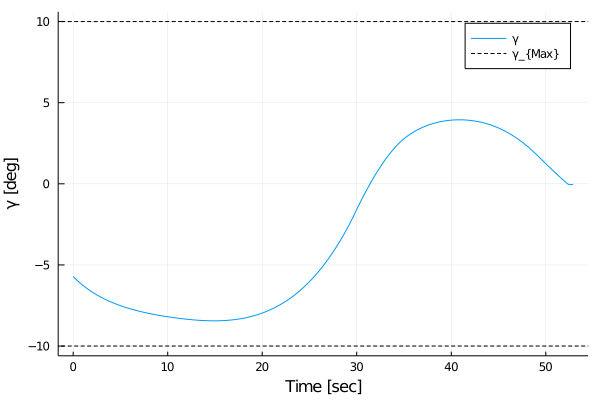

In [131]:
function γ(x)
    atan(x[2], x[1]) - x[5]
end
plot(tt[1:100:end], γ.(xx[1:100:end]) * 180/π, label="γ")
hline!([sc.γ, -sc.γ].*180/π,linestyle=:dash, color=:black, label="γ_{Max}")

xlabel!("Time [sec]")
ylabel!("γ [deg]")

┌ Info: Saved animation to 
│   fn = /Users/devanshagrawal/research/Input-Constrained-Control-Barrier-Functions/docking/tmp.gif
└ @ Plots /Users/devanshagrawal/.julia/packages/Plots/YicDu/src/animation.jl:104


Plots.AnimatedGif("/Users/devanshagrawal/research/Input-Constrained-Control-Barrier-Functions/docking/tmp.gif")
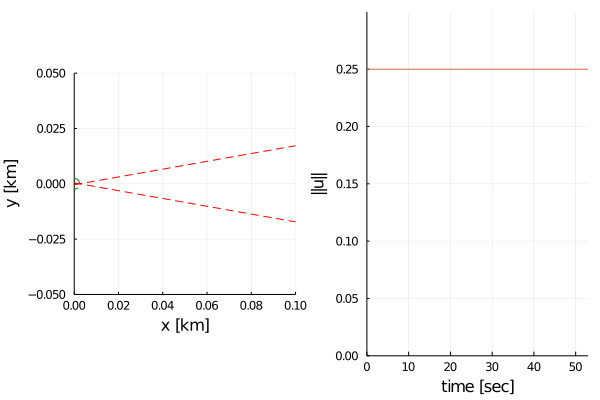

In [129]:
@gif for i=1:100:length(tt)
    
    l = @layout [:a, :b]
    
    p1 = plot(px[1:i], py[1:i], aspect_ratio=:equal, legend=false)
    xlims!(0, 0.1)
    ylims!(-0.05, 0.05)
    plot!(x-> sc.rp*sin(θθ[i]) + (x-sc.rp*cos(θθ[i]))*tan(sc.γ + θθ[i]), 0, 0.1, linestyle=:dash, color=:red)
    plot!(x-> sc.rp*sin(θθ[i]) + (x-sc.rp*cos(θθ[i]))*tan(-sc.γ + θθ[i]), 0, 0.1, linestyle=:dash, color=:red)
    plot!(x-> sc.rp*sin(x), x-> sc.rp*cos(x), 0, 2π, linestyle=:dash, color=:green)
    xlabel!("x [km]")
    ylabel!("y [km]")
    
    p2 = plot(tt[1:i], sqrt.(ux.^2 + uy.^2)[1:i], ylim=(0,1.2umax), xlim=(0, tt[end]), legend=false)
    hline!([umax])
    
    
    xlabel!("time [sec]")
    ylabel!("||u||")
    
    plot(p1, p2)
    
end

# 3D Vis

In [132]:
using MeshCat
using GeometryBasics
using CoordinateTransformations
using Rotations

In [133]:
function initialize_vis(x0)

    vis = Visualizer()

    scale=100

    d0 = scale * sc.rp
    d1 = scale * sc.rf
    l = scale * 0.1


    cyl = Cylinder(Point(-d1,0,0), Point(d1,0,0), d0)
    los_material = MeshPhongMaterial(color=RGBA(1, 0, 1, 0.15))
    los = Cone(Point(d0 + l, 0 , 0), Point(d0,0,0), l * atan(sc.γ))


    sph = Cone(Point(-0.25,0.,0.), Point(0,0.,0.), 0.05)
    sph_material = MeshPhongMaterial(color=RGBA(0, 1, 0, 1.0))

    setobject!(vis["group1"]["cyl"], cyl)
    setobject!(vis["group1"]["los"], los, los_material)
    
    setobject!(vis["group2"]["sph"], sph, sph_material)

    
    settransform!(vis["group2"],Translation(Point(scale*x0[1], scale*x0[2], 0))∘LinearMap(AngleAxis(π, 0, 0, 1)))
    
    θ = x0[5]
    settransform!(vis["group1"], LinearMap(AngleAxis(θ, 0, 0,1)))
    
    settransform!(vis["/Cameras/default"], LinearMap(AngleAxis(0.8π + x0[5], 0, 0, 1)))
    setprop!(vis["/Cameras/default/rotated/<object>"], "zoom", 2)
    return vis
end 

function animate_vis(vis, tt, xx)
    
    N = 300 # number of frames wanted
    Nextend = 330
    scale = 100
    
    anim=MeshCat.Animation(4800)
    
    atframe(anim, 1) do
        setprop!(vis["/Cameras/default/rotated/<object>"], "zoom", 0.2)
    end
    
    for i=1:Nextend
        

        ii = min(1, i/N)
        # closest frame
        fr = Integer(floor(length(tt) * ii))
        
        x0 = xx[fr]
        
        px = scale*x0[1]
        py = scale*x0[2]
        
        θ = x0[5]
        
        atframe(anim, fr) do
            
            cam  = 1/(1+exp(-10*(ii-0.8)))
            
            γ = atan(x0[4], x0[3])
            
            settransform!(vis["group1"], LinearMap(AngleAxis(θ, 0, 0, 1)))
            settransform!(vis["group2"], Translation(Point(px, py, 0))∘LinearMap(AngleAxis(γ, 0, 0, 1)))
            settransform!(vis["/Cameras/default"], LinearMap(AngleAxis(0.8π + θ + π * cam, 0, 0, 1)))
            setprop!(vis["/Cameras/default/rotated/<object>"], "zoom", 2 + 2*(ii)^2)
        end
    end
    

    setanimation!(vis, anim)
end

vis2 = initialize_vis(x0)

render(vis2)
animate_vis(vis2, tt, xx)
render(vis2)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8901
└ @ MeshCat /Users/devanshagrawal/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("Cameras" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("default" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x61, 0x73, 0x2f, 0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("rotated" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("<object>" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}("zoom" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x64, 0x2f, 0x3c, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x3e]), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))),"meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("group2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x63, 0x61, 0x74, 0x2f, 0x67, 0x72, 0x6f, 0x75, 0x70, 0x32], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("sph" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x72, 0x6f, 0x75, 0x70, 0x32, 0x2f, 0x73, 0x70, 0x68], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"group1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x63, 0x61, 0x74, 0x2f, 0x67, 0x72, 0x6f, 0x75, 0x70, 0x31], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("los" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x72, 0x6f, 0x75, 0x70, 0x31, 0x2f, 0x6c, 0x6f, 0x73], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x72, 0x6f, 0x75, 0x70, 0x31, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))), Set{Any}(), ip"127.0.0.1", 8901))